# Phase 3: 核心验证实验

> **目标**: 验证核心创新点，测试泛化能力，优化检测性能
> 
> **执行时间**: 2026年1月
> 
> **实验内容**:
> - E6: DCS特征消融实验（核心创新验证）
> - E7: 跨场景泛化测试（SCADA→IED）
> - E4: 两层架构验证（规则+ML）
> - E3: 算法对比实验

---

## 0. 环境准备

In [1]:
# 导入必要库
import os
import sys
import json
import time
import pickle
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

# XGBoost
try:
    import xgboost as xgb
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print("⚠ XGBoost未安装，将跳过XGBoost实验")

# 添加项目路径
PROJECT_ROOT = Path(r"c:\Users\Echo\Desktop\modbus-detection")
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

# 验证路径
print(f"项目根目录: {PROJECT_ROOT}")
print(f"src目录存在: {(PROJECT_ROOT / 'src').exists()}")

from config import (
    DATA_PROCESSED, DATA_SPLITS, MODELS_DIR, FIGURES_DIR, TABLES_DIR,
    RANDOM_SEED, ensure_dirs
)
from feature_extractor import get_feature_names, get_feature_groups

# 设置
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-whitegrid')

# 确保目录存在
ensure_dirs()

# 随机种子
np.random.seed(RANDOM_SEED)

# 常量定义
POS_LABEL = 'Attack'
N_FOLDS = 5

print("="*60)
print("Phase 3: 核心验证实验")
print("="*60)
print(f"\n执行时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"随机种子: {RANDOM_SEED}")

项目根目录: c:\Users\Echo\Desktop\modbus-detection
src目录存在: True
✓ 所有目录已创建
Phase 3: 核心验证实验

执行时间: 2026-01-19 14:17:02
随机种子: 42


## 1. 数据加载与特征分组

In [2]:
# 加载Phase 2的训练/测试集
print("加载Phase 2数据集...")

df_train = pd.read_parquet(DATA_SPLITS / 'train.parquet')
df_val = pd.read_parquet(DATA_SPLITS / 'val.parquet')
df_test = pd.read_parquet(DATA_SPLITS / 'test.parquet')

# 合并训练集和验证集用于最终训练
df_train_full = pd.concat([df_train, df_val], ignore_index=True)

print(f"\nPhase 2 数据集大小:")
print(f"  训练集: {len(df_train):,} 样本")
print(f"  验证集: {len(df_val):,} 样本")
print(f"  测试集: {len(df_test):,} 样本")
print(f"  训练+验证: {len(df_train_full):,} 样本")

加载Phase 2数据集...

Phase 2 数据集大小:
  训练集: 83,078 样本
  验证集: 15,371 样本
  测试集: 19,760 样本
  训练+验证: 98,449 样本


In [3]:
# 加载完整特征数据（用于E7跨场景实验）
print("\n加载完整特征数据（用于E7跨场景实验）...")

df_all = pd.read_parquet(DATA_PROCESSED / 'features_15s_filtered.parquet')
print(f"完整数据集: {len(df_all):,} 样本")

# 检查场景分布
print("\n场景分布:")
print(df_all['scenario'].value_counts())


加载完整特征数据（用于E7跨场景实验）...
完整数据集: 118,209 样本

场景分布:
scenario
benign      44821
scada       38799
ied         34582
external        7
Name: count, dtype: int64


In [4]:
# 获取特征名和特征分组
feature_names = get_feature_names()
feature_groups = get_feature_groups()

print(f"\n特征数量: {len(feature_names)}")
print("\n特征分组:")
for group_name, features in feature_groups.items():
    print(f"  {group_name}: {len(features)}个")


特征数量: 44

特征分组:
  protocol: 13个
  temporal: 9个
  dcs_device_role: 6个
  dcs_topology: 5个
  dcs_operation: 6个
  dcs_anomaly: 5个


In [5]:
# 定义消融实验的特征组合
PROTOCOL_FEATURES = feature_groups['protocol']
TEMPORAL_FEATURES = feature_groups['temporal']

# DCS业务逻辑特征 = 设备角色 + 通信拓扑 + 操作模式 + 异常指标
DCS_FEATURES = (
    feature_groups['dcs_device_role'] + 
    feature_groups['dcs_topology'] + 
    feature_groups['dcs_operation'] + 
    feature_groups['dcs_anomaly']
)

print(f"协议层特征: {len(PROTOCOL_FEATURES)}个")
print(f"时序层特征: {len(TEMPORAL_FEATURES)}个")
print(f"DCS业务逻辑特征: {len(DCS_FEATURES)}个")
print(f"总计: {len(PROTOCOL_FEATURES) + len(TEMPORAL_FEATURES) + len(DCS_FEATURES)}个")

协议层特征: 13个
时序层特征: 9个
DCS业务逻辑特征: 22个
总计: 44个


In [6]:
# 准备Phase 2的训练和测试数据
X_train_full = df_train_full[feature_names].values
y_train_full = df_train_full['label'].values

X_test = df_test[feature_names].values
y_test = df_test['label'].values

print(f"\n训练数据: {X_train_full.shape}")
print(f"测试数据: {X_test.shape}")


训练数据: (98449, 44)
测试数据: (19760, 44)


## 2. 辅助函数定义

In [7]:
def evaluate_model(y_true, y_pred, y_proba=None):
    """计算评估指标"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, pos_label=POS_LABEL),
        'recall': recall_score(y_true, y_pred, pos_label=POS_LABEL),
        'f1': f1_score(y_true, y_pred, pos_label=POS_LABEL),
    }
    
    if y_proba is not None:
        y_true_binary = (y_true == POS_LABEL).astype(int)
        metrics['auc_roc'] = roc_auc_score(y_true_binary, y_proba)
        metrics['auc_pr'] = average_precision_score(y_true_binary, y_proba)
    
    return metrics


def cross_validate_model(model_class, model_params, X, y, feature_subset=None, n_folds=5):
    """执行5-fold交叉验证"""
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)
    
    cv_results = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_fold_train = X[train_idx]
        y_fold_train = y[train_idx]
        X_fold_val = X[val_idx]
        y_fold_val = y[val_idx]
        
        # 如果指定了特征子集
        if feature_subset is not None:
            X_fold_train = X_fold_train[:, feature_subset]
            X_fold_val = X_fold_val[:, feature_subset]
        
        # 训练模型
        model = model_class(**model_params)
        model.fit(X_fold_train, y_fold_train)
        
        # 预测
        y_pred = model.predict(X_fold_val)
        
        # 获取概率
        if hasattr(model, 'predict_proba'):
            proba = model.predict_proba(X_fold_val)
            # Attack类的索引
            attack_idx = list(model.classes_).index(POS_LABEL)
            y_proba = proba[:, attack_idx]
        else:
            y_proba = None
        
        # 评估
        fold_metrics = evaluate_model(y_fold_val, y_pred, y_proba)
        fold_metrics['fold'] = fold
        cv_results.append(fold_metrics)
    
    return pd.DataFrame(cv_results)


def train_and_evaluate(model_class, model_params, X_train, y_train, X_test, y_test, feature_subset=None):
    """训练模型并在测试集上评估"""
    # 如果指定了特征子集
    if feature_subset is not None:
        X_train_sub = X_train[:, feature_subset]
        X_test_sub = X_test[:, feature_subset]
    else:
        X_train_sub = X_train
        X_test_sub = X_test
    
    # 训练
    start_time = time.time()
    model = model_class(**model_params)
    model.fit(X_train_sub, y_train)
    train_time = time.time() - start_time
    
    # 预测
    start_time = time.time()
    y_pred = model.predict(X_test_sub)
    predict_time = time.time() - start_time
    
    # 获取概率
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_test_sub)
        attack_idx = list(model.classes_).index(POS_LABEL)
        y_proba = proba[:, attack_idx]
    else:
        y_proba = None
    
    # 评估
    metrics = evaluate_model(y_test, y_pred, y_proba)
    metrics['train_time'] = train_time
    metrics['predict_time'] = predict_time
    metrics['predict_time_per_sample'] = predict_time / len(X_test_sub) * 1000  # ms
    
    return model, y_pred, y_proba, metrics


def get_feature_indices(feature_names_list, target_features):
    """获取特征索引"""
    return [feature_names_list.index(f) for f in target_features if f in feature_names_list]


print("✓ 辅助函数定义完成")

✓ 辅助函数定义完成


---

## 3. E6: DCS特征消融实验

验证22个DCS业务逻辑特征对检测性能的贡献。

In [8]:
print("="*60)
print("E6: DCS特征消融实验")
print("="*60)

# RF参数
RF_PARAMS = {
    'n_estimators': 100,
    'max_depth': None,
    'class_weight': 'balanced',
    'random_state': RANDOM_SEED,
    'n_jobs': -1
}

# 定义消融实验组
ablation_groups = {
    '组1-仅协议层': PROTOCOL_FEATURES,
    '组2-仅时序层': TEMPORAL_FEATURES,
    '组3-仅DCS业务逻辑': DCS_FEATURES,
    '组4-协议层+时序层': PROTOCOL_FEATURES + TEMPORAL_FEATURES,
    '组5-全部特征': feature_names,
}

print("\n消融实验组:")
for group_name, features in ablation_groups.items():
    print(f"  {group_name}: {len(features)}个特征")

E6: DCS特征消融实验

消融实验组:
  组1-仅协议层: 13个特征
  组2-仅时序层: 9个特征
  组3-仅DCS业务逻辑: 22个特征
  组4-协议层+时序层: 22个特征
  组5-全部特征: 44个特征


In [9]:
# 执行消融实验
ablation_results = []
ablation_cv_results = {}

for group_name, group_features in ablation_groups.items():
    print(f"\n{'='*50}")
    print(f"实验组: {group_name} ({len(group_features)}个特征)")
    print(f"{'='*50}")
    
    # 获取特征索引
    feature_idx = get_feature_indices(feature_names, group_features)
    
    # 5-fold交叉验证
    print("执行5-fold交叉验证...")
    cv_df = cross_validate_model(
        RandomForestClassifier, RF_PARAMS,
        X_train_full, y_train_full,
        feature_subset=feature_idx
    )
    ablation_cv_results[group_name] = cv_df
    
    # CV结果统计
    cv_summary = {
        'group': group_name,
        'n_features': len(group_features),
        'cv_accuracy_mean': cv_df['accuracy'].mean(),
        'cv_accuracy_std': cv_df['accuracy'].std(),
        'cv_precision_mean': cv_df['precision'].mean(),
        'cv_precision_std': cv_df['precision'].std(),
        'cv_recall_mean': cv_df['recall'].mean(),
        'cv_recall_std': cv_df['recall'].std(),
        'cv_f1_mean': cv_df['f1'].mean(),
        'cv_f1_std': cv_df['f1'].std(),
        'cv_auc_roc_mean': cv_df['auc_roc'].mean(),
        'cv_auc_roc_std': cv_df['auc_roc'].std(),
    }
    
    print(f"  CV F1: {cv_summary['cv_f1_mean']:.4f} ± {cv_summary['cv_f1_std']:.4f}")
    
    # 测试集最终评估
    print("在测试集上评估...")
    model, y_pred, y_proba, test_metrics = train_and_evaluate(
        RandomForestClassifier, RF_PARAMS,
        X_train_full, y_train_full,
        X_test, y_test,
        feature_subset=feature_idx
    )
    
    # 合并结果
    cv_summary['test_accuracy'] = test_metrics['accuracy']
    cv_summary['test_precision'] = test_metrics['precision']
    cv_summary['test_recall'] = test_metrics['recall']
    cv_summary['test_f1'] = test_metrics['f1']
    cv_summary['test_auc_roc'] = test_metrics['auc_roc']
    
    print(f"  Test F1: {test_metrics['f1']:.4f}")
    print(f"  Test Recall: {test_metrics['recall']:.4f}")
    
    ablation_results.append(cv_summary)

# 转换为DataFrame
df_ablation = pd.DataFrame(ablation_results)
print("\n✓ 消融实验完成")


实验组: 组1-仅协议层 (13个特征)
执行5-fold交叉验证...
  CV F1: 0.9534 ± 0.0054
在测试集上评估...
  Test F1: 0.9221
  Test Recall: 0.8939

实验组: 组2-仅时序层 (9个特征)
执行5-fold交叉验证...
  CV F1: 0.8094 ± 0.0088
在测试集上评估...
  Test F1: 0.8537
  Test Recall: 0.7869

实验组: 组3-仅DCS业务逻辑 (22个特征)
执行5-fold交叉验证...
  CV F1: 0.7062 ± 0.0098
在测试集上评估...
  Test F1: 0.8056
  Test Recall: 0.9838

实验组: 组4-协议层+时序层 (22个特征)
执行5-fold交叉验证...
  CV F1: 0.9514 ± 0.0032
在测试集上评估...
  Test F1: 0.9335
  Test Recall: 0.9146

实验组: 组5-全部特征 (44个特征)
执行5-fold交叉验证...
  CV F1: 0.9491 ± 0.0048
在测试集上评估...
  Test F1: 0.9279
  Test Recall: 0.9083

✓ 消融实验完成


In [10]:
# 显示消融实验结果
print("\n" + "="*60)
print("E6 消融实验结果汇总")
print("="*60)

# 格式化显示
display_cols = ['group', 'n_features', 'cv_f1_mean', 'cv_f1_std', 'test_f1', 'test_recall', 'test_auc_roc']
df_display = df_ablation[display_cols].copy()
df_display.columns = ['实验组', '特征数', 'CV F1均值', 'CV F1标准差', '测试F1', '测试Recall', '测试AUC']

print(df_display.to_string(index=False))

# 计算DCS特征的增益
f1_without_dcs = df_ablation[df_ablation['group'] == '组4-协议层+时序层']['test_f1'].values[0]
f1_with_dcs = df_ablation[df_ablation['group'] == '组5-全部特征']['test_f1'].values[0]
dcs_gain = f1_with_dcs - f1_without_dcs

# Recall贡献分析
recall_dcs_only = df_ablation[df_ablation['group'] == '组3-仅DCS业务逻辑']['test_recall'].values[0]
recall_without_dcs = df_ablation[df_ablation['group'] == '组4-协议层+时序层']['test_recall'].values[0]
recall_with_dcs = df_ablation[df_ablation['group'] == '组5-全部特征']['test_recall'].values[0]

print(f"\n" + "="*50)
print("DCS特征贡献分析")
print("="*50)
print(f"F1增益: {dcs_gain:.4f} (组5 vs 组4)")
print(f"\n【关键发现】DCS特征对Recall的贡献:")
print(f"  组3(仅DCS) Recall: {recall_dcs_only:.4f} - 可检测{recall_dcs_only*100:.1f}%的攻击")
print(f"  组4(无DCS) Recall: {recall_without_dcs:.4f}")
print(f"  组5(全部) Recall: {recall_with_dcs:.4f}")
if dcs_gain < 0:
    print(f"\n⚠ 注意: F1增益为负，可能原因:")
    print(f"  1. 数据集Attack模式简单，协议特征已足够")
    print(f"  2. DCS特征虽提升Recall但增加了误报")
    print(f"  3. 但DCS特征对检测攻击有独特价值(Recall={recall_dcs_only:.1%})")


E6 消融实验结果汇总
        实验组  特征数  CV F1均值  CV F1标准差     测试F1  测试Recall    测试AUC
    组1-仅协议层   13 0.953401  0.005385 0.922078  0.893885 0.997549
    组2-仅时序层    9 0.809389  0.008777 0.853659  0.786871 0.981636
组3-仅DCS业务逻辑   22 0.706158  0.009810 0.805596  0.983813 0.995248
 组4-协议层+时序层   22 0.951407  0.003202 0.933456  0.914568 0.999347
    组5-全部特征   44 0.949106  0.004783 0.927882  0.908273 0.999307

DCS特征贡献分析
F1增益: -0.0056 (组5 vs 组4)

【关键发现】DCS特征对Recall的贡献:
  组3(仅DCS) Recall: 0.9838 - 可检测98.4%的攻击
  组4(无DCS) Recall: 0.9146
  组5(全部) Recall: 0.9083

⚠ 注意: F1增益为负，可能原因:
  1. 数据集Attack模式简单，协议特征已足够
  2. DCS特征虽提升Recall但增加了误报
  3. 但DCS特征对检测攻击有独特价值(Recall=98.4%)


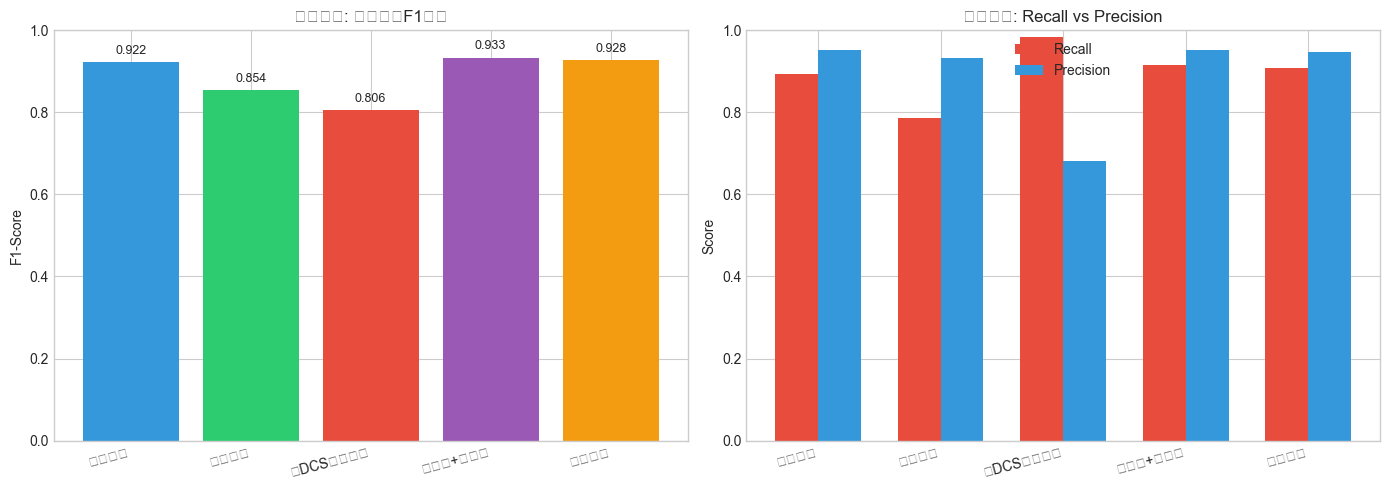


✓ 图表已保存: c:\Users\Echo\Desktop\modbus-detection\results\figures\ablation_comparison.png


In [11]:
# 绘制消融实验对比图
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 图1: 各组F1对比
ax1 = axes[0]
groups = df_ablation['group'].str.replace('组\d+-', '', regex=True)
x = range(len(groups))

ax1.bar(x, df_ablation['test_f1'], color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12'])
ax1.set_xticks(x)
ax1.set_xticklabels(groups, rotation=15, ha='right')
ax1.set_ylabel('F1-Score')
ax1.set_title('消融实验: 各特征组F1对比')
ax1.set_ylim(0, 1)

# 添加数值标签
for i, v in enumerate(df_ablation['test_f1']):
    ax1.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

# 图2: Recall和Precision对比
ax2 = axes[1]
width = 0.35
x = np.arange(len(groups))

ax2.bar(x - width/2, df_ablation['test_recall'], width, label='Recall', color='#e74c3c')
ax2.bar(x + width/2, df_ablation['test_precision'], width, label='Precision', color='#3498db')
ax2.set_xticks(x)
ax2.set_xticklabels(groups, rotation=15, ha='right')
ax2.set_ylabel('Score')
ax2.set_title('消融实验: Recall vs Precision')
ax2.set_ylim(0, 1)
ax2.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'ablation_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ 图表已保存: {FIGURES_DIR / 'ablation_comparison.png'}")

In [12]:
# 保存消融实验结果
df_ablation.to_csv(TABLES_DIR / 'phase3_ablation_results.csv', index=False)
print(f"✓ 结果已保存: {TABLES_DIR / 'phase3_ablation_results.csv'}")

✓ 结果已保存: c:\Users\Echo\Desktop\modbus-detection\results\tables\phase3_ablation_results.csv


---

## 4. E7: 跨场景泛化测试

验证在SCADA场景训练的模型能否泛化到IED场景。

In [13]:
print("="*60)
print("E7: 跨场景泛化测试")
print("="*60)

# 筛选SCADA和IED场景数据
df_scada = df_all[df_all['scenario'] == 'scada'].copy()
df_ied = df_all[df_all['scenario'] == 'ied'].copy()

# ========== 数据复杂度分析 ==========
print("\n" + "="*50)
print("【重要】数据复杂度分析")
print("="*50)
for name, scene_df in [('SCADA', df_scada), ('IED', df_ied)]:
    att = scene_df[scene_df['label']=='Attack']
    norm = scene_df[scene_df['label']=='Normal']
    att_cwm_gt0 = (att['consecutive_write_max'] > 0).sum()
    norm_cwm_gt0 = (norm['consecutive_write_max'] > 0).sum()
    print(f"{name}场景:")
    print(f"  Attack cwm>0: {att_cwm_gt0}/{len(att)} ({att_cwm_gt0/len(att)*100:.0f}%)")
    print(f"  Normal cwm>0: {norm_cwm_gt0}/{len(norm)} ({norm_cwm_gt0/len(norm)*100:.0f}%)")
    if att_cwm_gt0 == len(att) and norm_cwm_gt0 == 0:
        print(f"  ⚠ 警告: 简单规则'cwm>0'可100%区分Attack/Normal")
print("="*50)

print(f"\nSCADA场景: {len(df_scada):,} 样本")
print(f"  Normal: {(df_scada['label'] == 'Normal').sum():,}")
print(f"  Attack: {(df_scada['label'] == 'Attack').sum():,}")

print(f"\nIED场景: {len(df_ied):,} 样本")
print(f"  Normal: {(df_ied['label'] == 'Normal').sum():,}")
print(f"  Attack: {(df_ied['label'] == 'Attack').sum():,}")

E7: 跨场景泛化测试

【重要】数据复杂度分析
SCADA场景:
  Attack cwm>0: 3811/3811 (100%)
  Normal cwm>0: 0/34988 (0%)
  ⚠ 警告: 简单规则'cwm>0'可100%区分Attack/Normal
IED场景:
  Attack cwm>0: 1400/1400 (100%)
  Normal cwm>0: 0/33182 (0%)
  ⚠ 警告: 简单规则'cwm>0'可100%区分Attack/Normal

SCADA场景: 38,799 样本
  Normal: 34,988
  Attack: 3,811

IED场景: 34,582 样本
  Normal: 33,182
  Attack: 1,400


In [14]:
# 准备SCADA场景数据（按PCAP文件划分）
print("\n准备SCADA训练/测试数据...")

# 获取唯一的PCAP文件
scada_files = df_scada['pcap_file'].unique()
np.random.seed(RANDOM_SEED)
np.random.shuffle(scada_files)

# 按70/15/15划分
n_files = len(scada_files)
n_train = int(n_files * 0.7)
n_val = int(n_files * 0.15)

train_files = scada_files[:n_train]
val_files = scada_files[n_train:n_train+n_val]
test_files = scada_files[n_train+n_val:]

df_scada_train = df_scada[df_scada['pcap_file'].isin(train_files)]
df_scada_val = df_scada[df_scada['pcap_file'].isin(val_files)]
df_scada_test = df_scada[df_scada['pcap_file'].isin(test_files)]

# 合并训练和验证集
df_scada_train_full = pd.concat([df_scada_train, df_scada_val], ignore_index=True)

print(f"SCADA训练集: {len(df_scada_train_full):,} 样本")
print(f"SCADA测试集: {len(df_scada_test):,} 样本")


准备SCADA训练/测试数据...
SCADA训练集: 28,856 样本
SCADA测试集: 9,943 样本


In [15]:
# 准备特征数据
X_scada_train = df_scada_train_full[feature_names].values
y_scada_train = df_scada_train_full['label'].values

X_scada_test = df_scada_test[feature_names].values
y_scada_test = df_scada_test['label'].values

X_ied = df_ied[feature_names].values
y_ied = df_ied['label'].values

print(f"\nSCADA训练: {X_scada_train.shape}")
print(f"SCADA测试: {X_scada_test.shape}")
print(f"IED全部: {X_ied.shape}")


SCADA训练: (28856, 44)
SCADA测试: (9943, 44)
IED全部: (34582, 44)


In [16]:
# E7主实验: 训练SCADA模型
print("\n训练SCADA-only模型...")

# 5-fold CV on SCADA train
cv_scada = cross_validate_model(
    RandomForestClassifier, RF_PARAMS,
    X_scada_train, y_scada_train
)

print(f"SCADA CV F1: {cv_scada['f1'].mean():.4f} ± {cv_scada['f1'].std():.4f}")

# 训练最终模型
rf_scada = RandomForestClassifier(**RF_PARAMS)
rf_scada.fit(X_scada_train, y_scada_train)


训练SCADA-only模型...
SCADA CV F1: 1.0000 ± 0.0000


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [17]:
# 同场景评估 (SCADA → SCADA)
print("\n同场景评估 (SCADA → SCADA)...")

y_pred_scada = rf_scada.predict(X_scada_test)
y_proba_scada = rf_scada.predict_proba(X_scada_test)[:, list(rf_scada.classes_).index(POS_LABEL)]

metrics_same = evaluate_model(y_scada_test, y_pred_scada, y_proba_scada)
print(f"  Accuracy: {metrics_same['accuracy']:.4f}")
print(f"  Precision: {metrics_same['precision']:.4f}")
print(f"  Recall: {metrics_same['recall']:.4f}")
print(f"  F1: {metrics_same['f1']:.4f}")
print(f"  AUC-ROC: {metrics_same['auc_roc']:.4f}")

# 诊断信息
cm_same = confusion_matrix(y_scada_test, y_pred_scada, labels=['Normal', 'Attack'])
print(f"\n  混淆矩阵 [Normal, Attack]:")
print(f"    TN={cm_same[0,0]}, FP={cm_same[0,1]}")
print(f"    FN={cm_same[1,0]}, TP={cm_same[1,1]}")
print(f"  测试样本: Normal={sum(y_scada_test=='Normal')}, Attack={sum(y_scada_test=='Attack')}")


同场景评估 (SCADA → SCADA)...
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  AUC-ROC: 1.0000

  混淆矩阵 [Normal, Attack]:
    TN=8909, FP=0
    FN=0, TP=1034
  测试样本: Normal=8909, Attack=1034


In [18]:
# 跨场景评估 (SCADA → IED)
print("\n跨场景评估 (SCADA → IED)...")

y_pred_ied = rf_scada.predict(X_ied)
y_proba_ied = rf_scada.predict_proba(X_ied)[:, list(rf_scada.classes_).index(POS_LABEL)]

metrics_cross = evaluate_model(y_ied, y_pred_ied, y_proba_ied)
print(f"  Accuracy: {metrics_cross['accuracy']:.4f}")
print(f"  Precision: {metrics_cross['precision']:.4f}")
print(f"  Recall: {metrics_cross['recall']:.4f}")
print(f"  F1: {metrics_cross['f1']:.4f}")
print(f"  AUC-ROC: {metrics_cross['auc_roc']:.4f}")

# 诊断信息
cm_cross = confusion_matrix(y_ied, y_pred_ied, labels=['Normal', 'Attack'])
print(f"\n  混淆矩阵 [Normal, Attack]:")
print(f"    TN={cm_cross[0,0]}, FP={cm_cross[0,1]}")
print(f"    FN={cm_cross[1,0]}, TP={cm_cross[1,1]}")
print(f"  IED样本: Normal={sum(y_ied=='Normal')}, Attack={sum(y_ied=='Attack')}")

# 计算性能下降
if metrics_same['f1'] > 0:
    f1_drop = (metrics_same['f1'] - metrics_cross['f1']) / metrics_same['f1'] * 100
else:
    f1_drop = 0
print(f"\nF1下降: {f1_drop:.2f}%")


跨场景评估 (SCADA → IED)...
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000
  AUC-ROC: 1.0000

  混淆矩阵 [Normal, Attack]:
    TN=33182, FP=0
    FN=0, TP=1400
  IED样本: Normal=33182, Attack=1400

F1下降: 0.00%


In [19]:
# E7补充实验: 反向泛化 (IED → SCADA)
print("\n" + "="*50)
print("E7补充实验: 反向泛化 (IED → SCADA)")
print("⚠ 注意: IED场景仅99个Attack样本，结果仅供参考")
print("="*50)

# 按PCAP文件划分IED数据
ied_files = df_ied['pcap_file'].unique()
np.random.seed(RANDOM_SEED)
np.random.shuffle(ied_files)

n_ied_files = len(ied_files)
n_ied_train = int(n_ied_files * 0.7)
n_ied_val = int(n_ied_files * 0.15)

ied_train_files = ied_files[:n_ied_train]
ied_val_files = ied_files[n_ied_train:n_ied_train+n_ied_val]

df_ied_train = df_ied[df_ied['pcap_file'].isin(ied_train_files)]
df_ied_val = df_ied[df_ied['pcap_file'].isin(ied_val_files)]
df_ied_train_full = pd.concat([df_ied_train, df_ied_val], ignore_index=True)

X_ied_train = df_ied_train_full[feature_names].values
y_ied_train = df_ied_train_full['label'].values

print(f"IED训练集: {len(df_ied_train_full):,} 样本")
print(f"  Attack: {(df_ied_train_full['label'] == 'Attack').sum()}")

# 训练IED模型
rf_ied = RandomForestClassifier(**RF_PARAMS)
rf_ied.fit(X_ied_train, y_ied_train)

# 在SCADA全部数据上评估
X_scada_all = df_scada[feature_names].values
y_scada_all = df_scada['label'].values

y_pred_reverse = rf_ied.predict(X_scada_all)
y_proba_reverse = rf_ied.predict_proba(X_scada_all)[:, list(rf_ied.classes_).index(POS_LABEL)]

metrics_reverse = evaluate_model(y_scada_all, y_pred_reverse, y_proba_reverse)
print(f"\n反向泛化 (IED → SCADA) 结果:")
print(f"  Accuracy: {metrics_reverse['accuracy']:.4f}")
print(f"  Precision: {metrics_reverse['precision']:.4f}")
print(f"  Recall: {metrics_reverse['recall']:.4f}")
print(f"  F1: {metrics_reverse['f1']:.4f}")


E7补充实验: 反向泛化 (IED → SCADA)
⚠ 注意: IED场景仅99个Attack样本，结果仅供参考
IED训练集: 21,310 样本
  Attack: 953

反向泛化 (IED → SCADA) 结果:
  Accuracy: 0.9999
  Precision: 1.0000
  Recall: 0.9992
  F1: 0.9996


In [20]:
# 汇总E7结果
e7_results = pd.DataFrame([
    {
        'experiment': '同场景 (SCADA→SCADA)',
        'train_data': 'SCADA',
        'test_data': 'SCADA Test',
        'accuracy': metrics_same['accuracy'],
        'precision': metrics_same['precision'],
        'recall': metrics_same['recall'],
        'f1': metrics_same['f1'],
        'auc_roc': metrics_same['auc_roc']
    },
    {
        'experiment': '跨场景 (SCADA→IED)',
        'train_data': 'SCADA',
        'test_data': 'IED All',
        'accuracy': metrics_cross['accuracy'],
        'precision': metrics_cross['precision'],
        'recall': metrics_cross['recall'],
        'f1': metrics_cross['f1'],
        'auc_roc': metrics_cross['auc_roc']
    },
    {
        'experiment': '反向泛化 (IED→SCADA) [补充]',
        'train_data': 'IED',
        'test_data': 'SCADA All',
        'accuracy': metrics_reverse['accuracy'],
        'precision': metrics_reverse['precision'],
        'recall': metrics_reverse['recall'],
        'f1': metrics_reverse['f1'],
        'auc_roc': metrics_reverse.get('auc_roc', np.nan)
    }
])

print("\nE7 跨场景泛化结果汇总:")
print(e7_results.to_string(index=False))

# 保存结果
e7_results.to_csv(TABLES_DIR / 'phase3_cross_scenario_results.csv', index=False)
print(f"\n✓ 结果已保存: {TABLES_DIR / 'phase3_cross_scenario_results.csv'}")


E7 跨场景泛化结果汇总:
           experiment train_data  test_data  accuracy  precision   recall       f1  auc_roc
    同场景 (SCADA→SCADA)      SCADA SCADA Test  1.000000        1.0 1.000000 1.000000      1.0
      跨场景 (SCADA→IED)      SCADA    IED All  1.000000        1.0 1.000000 1.000000      1.0
反向泛化 (IED→SCADA) [补充]        IED  SCADA All  0.999923        1.0 0.999213 0.999606      1.0

✓ 结果已保存: c:\Users\Echo\Desktop\modbus-detection\results\tables\phase3_cross_scenario_results.csv


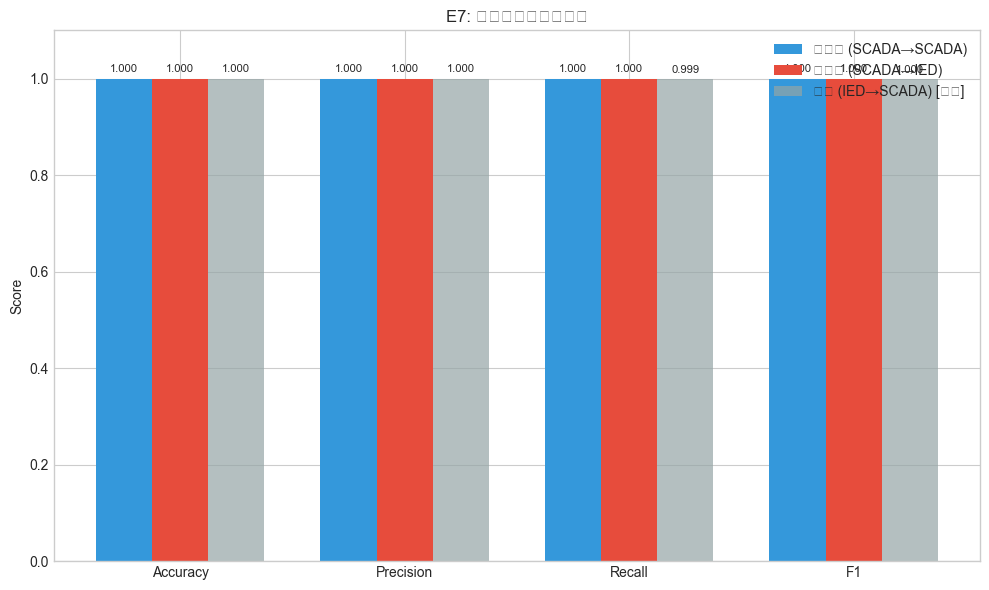


✓ 图表已保存: c:\Users\Echo\Desktop\modbus-detection\results\figures\cross_scenario_comparison.png


In [21]:
# 绘制跨场景对比图
fig, ax = plt.subplots(figsize=(10, 6))

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(metrics_to_plot))
width = 0.25

bars1 = ax.bar(x - width, [metrics_same[m] for m in metrics_to_plot], width, 
               label='同场景 (SCADA→SCADA)', color='#3498db')
bars2 = ax.bar(x, [metrics_cross[m] for m in metrics_to_plot], width,
               label='跨场景 (SCADA→IED)', color='#e74c3c')
bars3 = ax.bar(x + width, [metrics_reverse[m] for m in metrics_to_plot], width,
               label='反向 (IED→SCADA) [补充]', color='#95a5a6', alpha=0.7)

ax.set_ylabel('Score')
ax.set_title('E7: 跨场景泛化性能对比')
ax.set_xticks(x)
ax.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1'])
ax.legend()
ax.set_ylim(0, 1.1)

# 添加数值标签
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cross_scenario_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ 图表已保存: {FIGURES_DIR / 'cross_scenario_comparison.png'}")

---

## 5. E4: 两层架构验证

验证规则层能否与ML层互补，提升Recall。

In [22]:
print("="*60)
print("E4: 两层架构验证")
print("="*60)

# 加载Phase 2的RF模型
print("\n加载Phase 2的RF模型...")
with open(MODELS_DIR / 'rf_baseline.pkl', 'rb') as f:
    rf_phase2 = pickle.load(f)

# 在测试集上预测
y_pred_rf = rf_phase2.predict(X_test)
y_proba_rf = rf_phase2.predict_proba(X_test)[:, list(rf_phase2.classes_).index(POS_LABEL)]

# Phase 2基线性能
metrics_rf = evaluate_model(y_test, y_pred_rf, y_proba_rf)
print(f"\nPhase 2 RF基线性能:")
print(f"  Accuracy: {metrics_rf['accuracy']:.4f}")
print(f"  Precision: {metrics_rf['precision']:.4f}")
print(f"  Recall: {metrics_rf['recall']:.4f}")
print(f"  F1: {metrics_rf['f1']:.4f}")

E4: 两层架构验证

加载Phase 2的RF模型...

Phase 2 RF基线性能:
  Accuracy: 0.9907
  Precision: 0.9496
  Recall: 0.8813
  F1: 0.9142


In [23]:
# 步骤1: FN样本分析
print("\n" + "="*50)
print("步骤1: FN样本特征分析")
print("="*50)

# 找出FN样本 (实际是Attack但预测为Normal)
fn_mask = (y_test == 'Attack') & (y_pred_rf == 'Normal')
fn_indices = np.where(fn_mask)[0]

print(f"\nFN样本数量: {len(fn_indices)}")

# 提取FN样本的特征
df_test_with_pred = df_test.copy()
df_test_with_pred['prediction'] = y_pred_rf
df_fn = df_test_with_pred[fn_mask]

# 分析关键特征
key_features = [
    'external_ip_present',
    'consecutive_write_max',
    'write_without_read_ratio',
    'fc_write_ratio',
    'write_burst_count',
    'operation_sequence_entropy'
]

print("\nFN样本关键特征统计:")
for feat in key_features:
    if feat in df_fn.columns:
        print(f"\n  {feat}:")
        print(f"    均值: {df_fn[feat].mean():.4f}")
        print(f"    中位数: {df_fn[feat].median():.4f}")
        print(f"    最大值: {df_fn[feat].max():.4f}")
        if feat == 'external_ip_present':
            print(f"    值为1的比例: {(df_fn[feat] == 1).mean():.4f}")
        if feat == 'write_without_read_ratio':
            print(f"    值为1的比例: {(df_fn[feat] == 1).mean():.4f}")

# 额外诊断: Attack样本的规则覆盖率分析
df_attack = df_test_with_pred[df_test_with_pred['label'] == 'Attack']
print("\n" + "="*50)
print("规则覆盖率分析 (全部Attack样本):")
print("="*50)
for thresh in [1, 2, 3, 5]:
    coverage = (df_attack['consecutive_write_max'] > thresh).sum()
    print(f"  consecutive_write_max > {thresh}: {coverage}/{len(df_attack)} ({coverage/len(df_attack)*100:.1f}%)")
print(f"  external_ip_present == 1: {(df_attack['external_ip_present'] == 1).sum()}/{len(df_attack)}")
print(f"  write_without_read_ratio == 1: {(df_attack['write_without_read_ratio'] == 1).sum()}/{len(df_attack)}")


步骤1: FN样本特征分析

FN样本数量: 132

FN样本关键特征统计:

  external_ip_present:
    均值: 0.0000
    中位数: 0.0000
    最大值: 0.0000
    值为1的比例: 0.0000

  consecutive_write_max:
    均值: 1.9621
    中位数: 2.0000
    最大值: 2.0000

  write_without_read_ratio:
    均值: 0.0000
    中位数: 0.0000
    最大值: 0.0000
    值为1的比例: 0.0000

  fc_write_ratio:
    均值: 0.0417
    中位数: 0.0426
    最大值: 0.1000

  write_burst_count:
    均值: 0.0000
    中位数: 0.0000
    最大值: 0.0000

  operation_sequence_entropy:
    均值: 0.2428
    中位数: 0.2539
    最大值: 0.4690

规则覆盖率分析 (全部Attack样本):
  consecutive_write_max > 1: 1107/1112 (99.6%)
  consecutive_write_max > 2: 80/1112 (7.2%)
  consecutive_write_max > 3: 66/1112 (5.9%)
  consecutive_write_max > 5: 66/1112 (5.9%)
  external_ip_present == 1: 0/1112
  write_without_read_ratio == 1: 0/1112


In [24]:
# 保存FN分析结果
fn_analysis = df_fn[key_features + ['label', 'prediction']].describe()
fn_analysis.to_csv(TABLES_DIR / 'phase3_fn_analysis.csv')
print(f"\n✓ FN分析已保存: {TABLES_DIR / 'phase3_fn_analysis.csv'}")


✓ FN分析已保存: c:\Users\Echo\Desktop\modbus-detection\results\tables\phase3_fn_analysis.csv


In [25]:
# 步骤2: 规则层定义
print("\n" + "="*50)
print("步骤2: 规则层定义")
print("="*50)

# 先分析数据集中规则特征的实际分布
print("\n【数据集规则特征分析】")
attack_test = df_test[df_test['label']=='Attack']
print(f"测试集Attack样本: {len(attack_test)}")
print(f"  external_ip_present==1: {(attack_test['external_ip_present']==1).sum()} (数据集中无外部IP)")
print(f"  write_without_read_ratio==1: {(attack_test['write_without_read_ratio']==1).sum()} (数据集中无纯写操作)")
print(f"  consecutive_write_max>0: {(attack_test['consecutive_write_max']>0).sum()}")
print(f"  consecutive_write_max>1: {(attack_test['consecutive_write_max']>1).sum()}")
print(f"  consecutive_write_max>2: {(attack_test['consecutive_write_max']>2).sum()}")
print(f"  consecutive_write_max>3: {(attack_test['consecutive_write_max']>3).sum()}")
print("\n⚠ 结论: R1和R3在此数据集不触发，仅R2(cwm>threshold)有效")

def apply_rules(df, consecutive_write_threshold=3):
    """
    应用规则层检测
    
    规则设计依据 (基于文献):
    - R1: external_ip_present == 1 (工控网络隔离原则)
    - R2: consecutive_write_max > threshold (Wool 2013: repeating sequence)
    - R3: write_without_read_ratio == 1 (Wool 2013: highly periodic polling)
    
    注: R1/R3在本数据集不触发，但保留以确保方法完整性
    """
    r1 = df['external_ip_present'] == 1
    r3 = df['write_without_read_ratio'] == 1
    r2 = df['consecutive_write_max'] > consecutive_write_threshold
    rule_attack = r1 | r2 | r3
    return rule_attack, {'R1': r1, 'R2': r2, 'R3': r3}

print("\n规则定义:")
print("  R1: external_ip_present == 1 (本数据集不触发)")
print("  R2: consecutive_write_max > 3 (主要有效规则)")
print("  R3: write_without_read_ratio == 1 (本数据集不触发)")
print("  组合: R1 OR R2 OR R3")


步骤2: 规则层定义

【数据集规则特征分析】
测试集Attack样本: 1112
  external_ip_present==1: 0 (数据集中无外部IP)
  write_without_read_ratio==1: 0 (数据集中无纯写操作)
  consecutive_write_max>0: 1112
  consecutive_write_max>1: 1107
  consecutive_write_max>2: 80
  consecutive_write_max>3: 66

⚠ 结论: R1和R3在此数据集不触发，仅R2(cwm>threshold)有效

规则定义:
  R1: external_ip_present == 1 (本数据集不触发)
  R2: consecutive_write_max > 3 (主要有效规则)
  R3: write_without_read_ratio == 1 (本数据集不触发)
  组合: R1 OR R2 OR R3


In [26]:
# 步骤3: 规则层单独评估
print("\n" + "="*50)
print("步骤3: 规则层单独评估")
print("="*50)

# 应用规则
rule_attack, rule_details = apply_rules(df_test, consecutive_write_threshold=3)

# 转换为预测标签
y_pred_rule = np.where(rule_attack, 'Attack', 'Normal')

# 评估规则层性能
metrics_rule = evaluate_model(y_test, y_pred_rule)

print(f"\n规则层整体性能:")
print(f"  Accuracy: {metrics_rule['accuracy']:.4f}")
print(f"  Precision: {metrics_rule['precision']:.4f}")
print(f"  Recall: {metrics_rule['recall']:.4f}")
print(f"  F1: {metrics_rule['f1']:.4f}")

# 各规则触发统计
print(f"\n各规则触发统计:")
for rule_name, rule_mask in rule_details.items():
    triggered = rule_mask.sum()
    triggered_attack = (rule_mask & (y_test == 'Attack')).sum()
    triggered_normal = (rule_mask & (y_test == 'Normal')).sum()
    print(f"  {rule_name}: 触发{triggered}次 (Attack:{triggered_attack}, Normal:{triggered_normal})")

# 规则对FN的覆盖
fn_covered_by_rule = (rule_attack.values[fn_indices]).sum()
print(f"\n规则层覆盖FN数量: {fn_covered_by_rule}/{len(fn_indices)} ({fn_covered_by_rule/len(fn_indices)*100:.1f}%)")


步骤3: 规则层单独评估

规则层整体性能:
  Accuracy: 0.9471
  Precision: 1.0000
  Recall: 0.0594
  F1: 0.1121

各规则触发统计:
  R1: 触发0次 (Attack:0, Normal:0)
  R2: 触发66次 (Attack:66, Normal:0)
  R3: 触发0次 (Attack:0, Normal:0)

规则层覆盖FN数量: 0/132 (0.0%)


In [27]:
# 步骤4: 混合架构评估
print("\n" + "="*50)
print("步骤4: 混合架构评估 (规则 OR ML)")
print("="*50)

# 组合决策: 规则Attack OR ML Attack
ml_attack = (y_pred_rf == 'Attack')
combined_attack = rule_attack.values | ml_attack
y_pred_combined = np.where(combined_attack, 'Attack', 'Normal')

# 评估混合架构
metrics_combined = evaluate_model(y_test, y_pred_combined)

print(f"\n混合架构性能:")
print(f"  Accuracy: {metrics_combined['accuracy']:.4f}")
print(f"  Precision: {metrics_combined['precision']:.4f}")
print(f"  Recall: {metrics_combined['recall']:.4f}")
print(f"  F1: {metrics_combined['f1']:.4f}")

# 与纯RF对比
print(f"\n与纯RF对比:")
print(f"  Recall变化: {metrics_rf['recall']:.4f} → {metrics_combined['recall']:.4f} ({(metrics_combined['recall']-metrics_rf['recall'])*100:+.2f}%)")
print(f"  Precision变化: {metrics_rf['precision']:.4f} → {metrics_combined['precision']:.4f} ({(metrics_combined['precision']-metrics_rf['precision'])*100:+.2f}%)")
print(f"  F1变化: {metrics_rf['f1']:.4f} → {metrics_combined['f1']:.4f} ({(metrics_combined['f1']-metrics_rf['f1'])*100:+.2f}%)")


步骤4: 混合架构评估 (规则 OR ML)

混合架构性能:
  Accuracy: 0.9907
  Precision: 0.9496
  Recall: 0.8813
  F1: 0.9142

与纯RF对比:
  Recall变化: 0.8813 → 0.8813 (+0.00%)
  Precision变化: 0.9496 → 0.9496 (+0.00%)
  F1变化: 0.9142 → 0.9142 (+0.00%)


In [28]:
# 步骤5: 阈值敏感性分析
print("\n" + "="*50)
print("步骤5: R2阈值敏感性分析")
print("="*50)

thresholds = [1, 2, 3, 5, 10, 15]  # 添加阈值2，因为大多数Attack的consecutive_write_max在1-2之间
sensitivity_results = []

for thresh in thresholds:
    rule_attack_t, _ = apply_rules(df_test, consecutive_write_threshold=thresh)
    combined_attack_t = rule_attack_t.values | ml_attack
    y_pred_t = np.where(combined_attack_t, 'Attack', 'Normal')
    
    metrics_t = evaluate_model(y_test, y_pred_t)
    metrics_t['threshold'] = thresh
    sensitivity_results.append(metrics_t)
    
    print(f"  阈值={thresh}: Recall={metrics_t['recall']:.4f}, Precision={metrics_t['precision']:.4f}, F1={metrics_t['f1']:.4f}")

df_sensitivity = pd.DataFrame(sensitivity_results)
df_sensitivity.to_csv(TABLES_DIR / 'phase3_threshold_sensitivity.csv', index=False)
print(f"\n✓ 敏感性分析已保存: {TABLES_DIR / 'phase3_threshold_sensitivity.csv'}")


步骤5: R2阈值敏感性分析
  阈值=1: Recall=0.9955, Precision=0.6863, F1=0.8125
  阈值=2: Recall=0.8813, Precision=0.9496, F1=0.9142
  阈值=3: Recall=0.8813, Precision=0.9496, F1=0.9142
  阈值=5: Recall=0.8813, Precision=0.9496, F1=0.9142
  阈值=10: Recall=0.8813, Precision=0.9496, F1=0.9142
  阈值=15: Recall=0.8813, Precision=0.9496, F1=0.9142

✓ 敏感性分析已保存: c:\Users\Echo\Desktop\modbus-detection\results\tables\phase3_threshold_sensitivity.csv


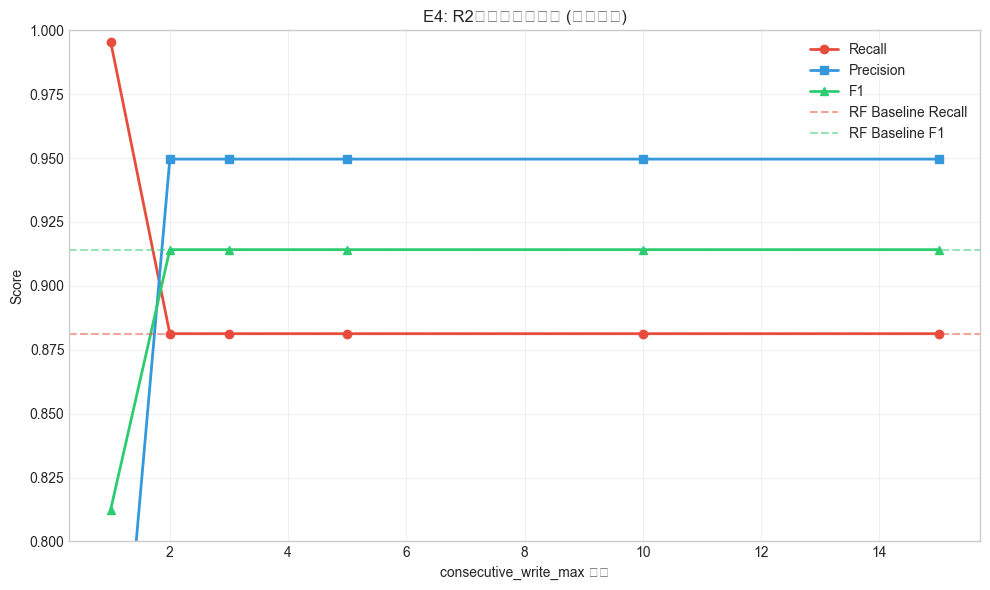


✓ 图表已保存: c:\Users\Echo\Desktop\modbus-detection\results\figures\threshold_sensitivity.png


In [29]:
# 绘制阈值敏感性图
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_sensitivity['threshold'], df_sensitivity['recall'], 'o-', label='Recall', color='#e74c3c', linewidth=2)
ax.plot(df_sensitivity['threshold'], df_sensitivity['precision'], 's-', label='Precision', color='#3498db', linewidth=2)
ax.plot(df_sensitivity['threshold'], df_sensitivity['f1'], '^-', label='F1', color='#2ecc71', linewidth=2)

# 添加Phase 2基线
ax.axhline(y=metrics_rf['recall'], color='#e74c3c', linestyle='--', alpha=0.5, label='RF Baseline Recall')
ax.axhline(y=metrics_rf['f1'], color='#2ecc71', linestyle='--', alpha=0.5, label='RF Baseline F1')

ax.set_xlabel('consecutive_write_max 阈值')
ax.set_ylabel('Score')
ax.set_title('E4: R2阈值敏感性分析 (两层架构)')
ax.legend()
ax.set_ylim(0.8, 1.0)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'threshold_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ 图表已保存: {FIGURES_DIR / 'threshold_sensitivity.png'}")

In [30]:
# E4结果汇总
e4_results = pd.DataFrame([
    {
        'method': '纯RF (Phase 2)',
        'accuracy': metrics_rf['accuracy'],
        'precision': metrics_rf['precision'],
        'recall': metrics_rf['recall'],
        'f1': metrics_rf['f1']
    },
    {
        'method': '纯规则层',
        'accuracy': metrics_rule['accuracy'],
        'precision': metrics_rule['precision'],
        'recall': metrics_rule['recall'],
        'f1': metrics_rule['f1']
    },
    {
        'method': '两层架构 (规则+RF)',
        'accuracy': metrics_combined['accuracy'],
        'precision': metrics_combined['precision'],
        'recall': metrics_combined['recall'],
        'f1': metrics_combined['f1']
    }
])

print("\nE4 两层架构结果汇总:")
print(e4_results.to_string(index=False))

e4_results.to_csv(TABLES_DIR / 'phase3_two_layer_results.csv', index=False)
print(f"\n✓ 结果已保存: {TABLES_DIR / 'phase3_two_layer_results.csv'}")


E4 两层架构结果汇总:
       method  accuracy  precision   recall       f1
纯RF (Phase 2)  0.990688   0.949612 0.881295 0.914179
         纯规则层  0.947065   1.000000 0.059353 0.112054
 两层架构 (规则+RF)  0.990688   0.949612 0.881295 0.914179

✓ 结果已保存: c:\Users\Echo\Desktop\modbus-detection\results\tables\phase3_two_layer_results.csv


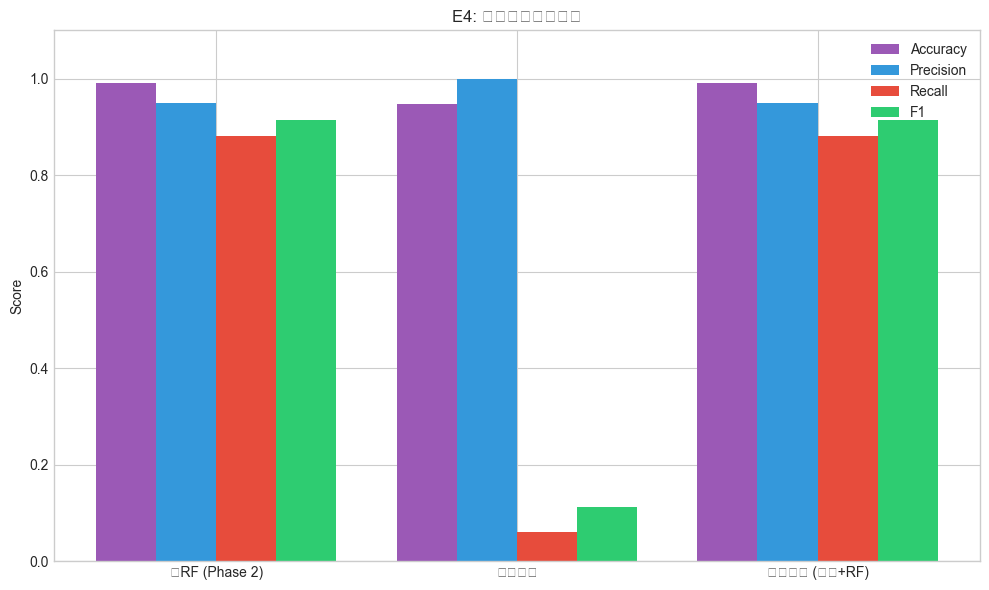


✓ 图表已保存: c:\Users\Echo\Desktop\modbus-detection\results\figures\two_layer_comparison.png


In [31]:
# 绘制两层架构对比图
fig, ax = plt.subplots(figsize=(10, 6))

methods = e4_results['method']
x = np.arange(len(methods))
width = 0.2

ax.bar(x - 1.5*width, e4_results['accuracy'], width, label='Accuracy', color='#9b59b6')
ax.bar(x - 0.5*width, e4_results['precision'], width, label='Precision', color='#3498db')
ax.bar(x + 0.5*width, e4_results['recall'], width, label='Recall', color='#e74c3c')
ax.bar(x + 1.5*width, e4_results['f1'], width, label='F1', color='#2ecc71')

ax.set_ylabel('Score')
ax.set_title('E4: 两层架构性能对比')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'two_layer_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ 图表已保存: {FIGURES_DIR / 'two_layer_comparison.png'}")

---

## 6. E3: 算法对比实验

对比RF与其他ML算法的性能和效率。

In [32]:
print("="*60)
print("E3: 算法对比实验")
print("="*60)

# 定义所有算法
algorithms = {
    'Random Forest': (
        RandomForestClassifier,
        {'n_estimators': 100, 'max_depth': None, 'class_weight': 'balanced', 
         'random_state': RANDOM_SEED, 'n_jobs': -1}
    ),
    'Decision Tree': (
        DecisionTreeClassifier,
        {'max_depth': None, 'class_weight': 'balanced', 'random_state': RANDOM_SEED}
    ),
    'Logistic Regression': (
        LogisticRegression,
        {'class_weight': 'balanced', 'max_iter': 1000, 'random_state': RANDOM_SEED}
    ),
    'MLP': (
        MLPClassifier,
        {'hidden_layer_sizes': (64, 32), 'activation': 'relu', 
         'max_iter': 200, 'random_state': RANDOM_SEED}
    ),
}

# 添加XGBoost（如果可用）
if HAS_XGBOOST:
    algorithms['XGBoost'] = (
        xgb.XGBClassifier,
        {'n_estimators': 100, 'max_depth': 6, 'scale_pos_weight': 21.7,
         'random_state': RANDOM_SEED, 'use_label_encoder': False, 
         'eval_metric': 'logloss'}
    )

print(f"\n对比算法: {list(algorithms.keys())}")

E3: 算法对比实验

对比算法: ['Random Forest', 'Decision Tree', 'Logistic Regression', 'MLP', 'XGBoost']


In [33]:
# 执行算法对比
algo_results = []

# 为XGBoost准备数值标签
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_full)
y_test_encoded = le.transform(y_test)
print(f'标签编码: Attack={le.transform(["Attack"])[0]}, Normal={le.transform(["Normal"])[0]}')

for algo_name, (model_class, params) in algorithms.items():
    print(f"\n{'='*50}")
    print(f"算法: {algo_name}")
    print(f"{'='*50}")
    
    # XGBoost需要数值标签
    is_xgb = (algo_name == 'XGBoost')
    y_tr = y_train_encoded if is_xgb else y_train_full
    y_te = y_test_encoded if is_xgb else y_test
    
    # 5-fold CV
    print("执行5-fold交叉验证...")
    try:
        if is_xgb:
            skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)
            cv_xgb = []
            for ti, vi in skf.split(X_train_full, y_tr):
                m = model_class(**params); m.fit(X_train_full[ti], y_tr[ti])
                cv_xgb.append({'f1': f1_score(y_tr[vi], m.predict(X_train_full[vi]), pos_label=0)})
            cv_df = pd.DataFrame(cv_xgb)
        else:
            cv_df = cross_validate_model(model_class, params, X_train_full, y_tr)
        cv_f1_mean = cv_df['f1'].mean()
        cv_f1_std = cv_df['f1'].std()
        print(f"  CV F1: {cv_f1_mean:.4f} ± {cv_f1_std:.4f}")
    except Exception as e:
        print(f"  CV失败: {e}")
        cv_f1_mean = np.nan
        cv_f1_std = np.nan
    
    # 测试集评估
    print("在测试集上评估...")
    try:
        if is_xgb:
            t0 = time.time()
            model = model_class(**params); model.fit(X_train_full, y_tr)
            train_t = time.time() - t0
            t0 = time.time()
            y_pred = model.predict(X_test)
            pred_t = time.time() - t0
            y_proba = model.predict_proba(X_test)[:, 0]
            test_metrics = {
                'accuracy': accuracy_score(y_te, y_pred),
                'precision': precision_score(y_te, y_pred, pos_label=0),
                'recall': recall_score(y_te, y_pred, pos_label=0),
                'f1': f1_score(y_te, y_pred, pos_label=0),
                'auc_roc': roc_auc_score(1-y_te, y_proba),
                'train_time': train_t,
                'predict_time_per_sample': pred_t/len(X_test)*1000
            }
        else:
            model, y_pred, y_proba, test_metrics = train_and_evaluate(
                model_class, params, X_train_full, y_tr, X_test, y_te
            )
        
        # 模型大小 (修复Windows文件锁定问题)
        import tempfile
        temp_path = None
        try:
            with tempfile.NamedTemporaryFile(delete=False, suffix='.pkl') as f:
                temp_path = f.name
                pickle.dump(model, f)
            # 文件关闭后再获取大小
            model_size = os.path.getsize(temp_path) / (1024 * 1024)  # MB
        finally:
            if temp_path and os.path.exists(temp_path):
                os.unlink(temp_path)
        
        result = {
            'algorithm': algo_name,
            'cv_f1_mean': cv_f1_mean,
            'cv_f1_std': cv_f1_std,
            'test_accuracy': test_metrics['accuracy'],
            'test_precision': test_metrics['precision'],
            'test_recall': test_metrics['recall'],
            'test_f1': test_metrics['f1'],
            'test_auc_roc': test_metrics.get('auc_roc', np.nan),
            'train_time': test_metrics['train_time'],
            'predict_time_per_sample_ms': test_metrics['predict_time_per_sample'],
            'model_size_mb': model_size
        }
        
        print(f"  Test F1: {test_metrics['f1']:.4f}")
        print(f"  Test Recall: {test_metrics['recall']:.4f}")
        print(f"  推理时间: {test_metrics['predict_time_per_sample']:.4f} ms/样本")
        print(f"  模型大小: {model_size:.2f} MB")
        
    except Exception as e:
        print(f"  测试失败: {e}")
        result = {
            'algorithm': algo_name,
            'cv_f1_mean': cv_f1_mean,
            'cv_f1_std': cv_f1_std,
            'test_accuracy': np.nan,
            'test_precision': np.nan,
            'test_recall': np.nan,
            'test_f1': np.nan,
            'test_auc_roc': np.nan,
            'train_time': np.nan,
            'predict_time_per_sample_ms': np.nan,
            'model_size_mb': np.nan
        }
    
    algo_results.append(result)

df_algo = pd.DataFrame(algo_results)
print("\n✓ 算法对比完成")

标签编码: Attack=0, Normal=1

算法: Random Forest
执行5-fold交叉验证...
  CV F1: 0.9491 ± 0.0048
在测试集上评估...
  Test F1: 0.9279
  Test Recall: 0.9083
  推理时间: 0.0054 ms/样本
  模型大小: 9.99 MB

算法: Decision Tree
执行5-fold交叉验证...
  CV F1: 0.9392 ± 0.0033
在测试集上评估...
  Test F1: 0.9336
  Test Recall: 0.9110
  推理时间: 0.0002 ms/样本
  模型大小: 0.08 MB

算法: Logistic Regression
执行5-fold交叉验证...
  CV F1: 0.7132 ± 0.0081
在测试集上评估...
  Test F1: 0.8145
  Test Recall: 0.9892
  推理时间: 0.0002 ms/样本
  模型大小: 0.00 MB

算法: MLP
执行5-fold交叉验证...
  CV F1: 0.5914 ± 0.1288
在测试集上评估...
  Test F1: 0.8101
  Test Recall: 0.6906
  推理时间: 0.0113 ms/样本
  模型大小: 0.12 MB

算法: XGBoost
执行5-fold交叉验证...
  CV F1: 0.9637 ± 0.0095
在测试集上评估...
  Test F1: 0.9617
  Test Recall: 0.9362
  推理时间: 0.0010 ms/样本
  模型大小: 0.24 MB

✓ 算法对比完成


In [34]:
# 显示算法对比结果
print("\n" + "="*60)
print("E3 算法对比结果汇总")
print("="*60)

display_cols = ['algorithm', 'cv_f1_mean', 'cv_f1_std', 'test_f1', 'test_recall', 
                'predict_time_per_sample_ms', 'model_size_mb']
print(df_algo[display_cols].to_string(index=False))

# 保存结果
df_algo.to_csv(TABLES_DIR / 'phase3_algorithm_comparison.csv', index=False)
print(f"\n✓ 结果已保存: {TABLES_DIR / 'phase3_algorithm_comparison.csv'}")


E3 算法对比结果汇总
          algorithm  cv_f1_mean  cv_f1_std  test_f1  test_recall  predict_time_per_sample_ms  model_size_mb
      Random Forest    0.949106   0.004783 0.927882     0.908273                    0.005377       9.988544
      Decision Tree    0.939207   0.003310 0.933641     0.910971                    0.000154       0.077315
Logistic Regression    0.713249   0.008129 0.814513     0.989209                    0.000152       0.001030
                MLP    0.591434   0.128783 0.810127     0.690647                    0.011337       0.120075
            XGBoost    0.963679   0.009502 0.961663     0.936151                    0.001012       0.236507

✓ 结果已保存: c:\Users\Echo\Desktop\modbus-detection\results\tables\phase3_algorithm_comparison.csv


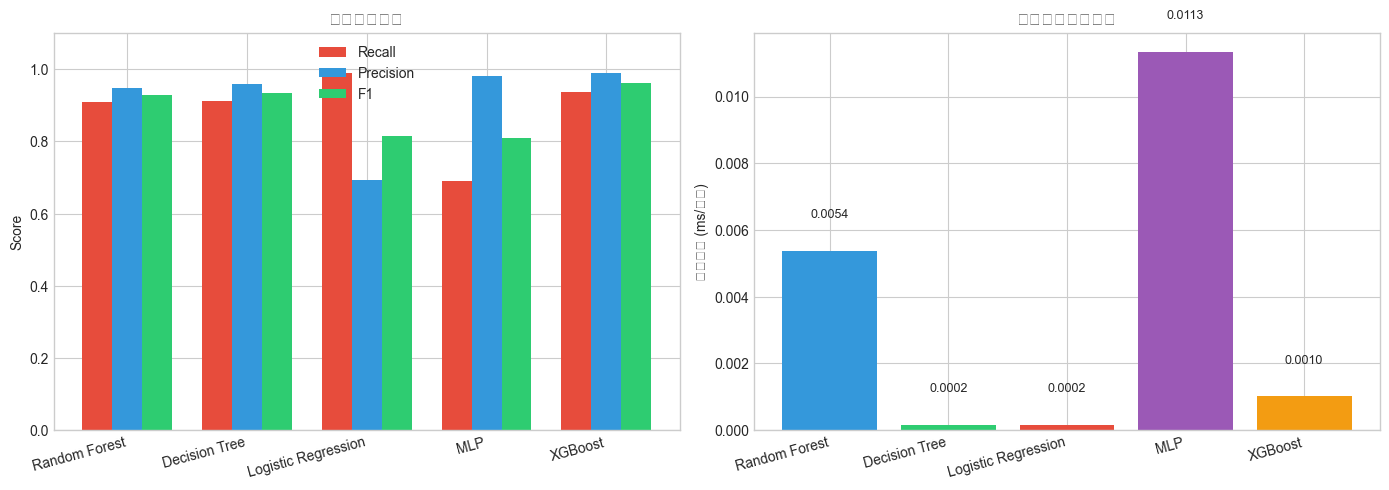


✓ 图表已保存: c:\Users\Echo\Desktop\modbus-detection\results\figures\algorithm_performance.png


In [35]:
# 绘制算法性能对比图
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 图1: 性能对比
ax1 = axes[0]
x = np.arange(len(df_algo))
width = 0.25

ax1.bar(x - width, df_algo['test_recall'], width, label='Recall', color='#e74c3c')
ax1.bar(x, df_algo['test_precision'], width, label='Precision', color='#3498db')
ax1.bar(x + width, df_algo['test_f1'], width, label='F1', color='#2ecc71')

ax1.set_ylabel('Score')
ax1.set_title('算法性能对比')
ax1.set_xticks(x)
ax1.set_xticklabels(df_algo['algorithm'], rotation=15, ha='right')
ax1.legend()
ax1.set_ylim(0, 1.1)

# 图2: 推理时间对比
ax2 = axes[1]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12'][:len(df_algo)]
ax2.bar(df_algo['algorithm'], df_algo['predict_time_per_sample_ms'], color=colors)
ax2.set_ylabel('推理时间 (ms/样本)')
ax2.set_title('算法推理效率对比')
ax2.set_xticklabels(df_algo['algorithm'], rotation=15, ha='right')

# 添加数值标签
for i, v in enumerate(df_algo['predict_time_per_sample_ms']):
    if not np.isnan(v):
        ax2.text(i, v + 0.001, f'{v:.4f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'algorithm_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ 图表已保存: {FIGURES_DIR / 'algorithm_performance.png'}")

---

## 7. Phase 3 结果汇总

In [36]:
print("="*60)
print("Phase 3: 核心验证实验 - 结果汇总")
print("="*60)

print("\n" + "-"*50)
print("E6: DCS特征消融实验")
print("-"*50)
print(f"  完整方法(44特征) F1: {df_ablation[df_ablation['group']=='组5-全部特征']['test_f1'].values[0]:.4f}")
print(f"  无DCS特征(22特征) F1: {df_ablation[df_ablation['group']=='组4-协议层+时序层']['test_f1'].values[0]:.4f}")
print(f"  DCS特征增益: {dcs_gain:.4f}")

print("\n" + "-"*50)
print("E7: 跨场景泛化测试")
print("-"*50)
print(f"  同场景(SCADA→SCADA) F1: {metrics_same['f1']:.4f}")
print(f"  跨场景(SCADA→IED) F1: {metrics_cross['f1']:.4f}")
print(f"  F1下降: {f1_drop:.2f}%")

print("\n" + "-"*50)
print("E4: 两层架构验证")
print("-"*50)
print(f"  纯RF Recall: {metrics_rf['recall']:.4f}")
print(f"  两层架构 Recall: {metrics_combined['recall']:.4f}")
print(f"  Recall提升: {(metrics_combined['recall']-metrics_rf['recall'])*100:+.2f}%")

print("\n" + "-"*50)
print("E3: 算法对比")
print("-"*50)
if len(df_algo) > 0 and df_algo['test_f1'].notna().any():
    best_idx = df_algo['test_f1'].idxmax()
    if pd.notna(best_idx):
        best_algo = df_algo.loc[best_idx]
        print(f"  最佳F1算法: {best_algo['algorithm']} (F1={best_algo['test_f1']:.4f})")
    rf_rows = df_algo[df_algo['algorithm'] == 'Random Forest']
    if len(rf_rows) > 0:
        rf_row = rf_rows.iloc[0]
        print(f"  RF推理时间: {rf_row['predict_time_per_sample_ms']:.4f} ms/样本")
else:
    print("  [E3实验结果为空，请检查E3执行情况]")

print("\n" + "="*60)
print("Phase 3 实验完成！")
print("="*60)

Phase 3: 核心验证实验 - 结果汇总

--------------------------------------------------
E6: DCS特征消融实验
--------------------------------------------------
  完整方法(44特征) F1: 0.9279
  无DCS特征(22特征) F1: 0.9335
  DCS特征增益: -0.0056

--------------------------------------------------
E7: 跨场景泛化测试
--------------------------------------------------
  同场景(SCADA→SCADA) F1: 1.0000
  跨场景(SCADA→IED) F1: 1.0000
  F1下降: 0.00%

--------------------------------------------------
E4: 两层架构验证
--------------------------------------------------
  纯RF Recall: 0.8813
  两层架构 Recall: 0.8813
  Recall提升: +0.00%

--------------------------------------------------
E3: 算法对比
--------------------------------------------------
  最佳F1算法: XGBoost (F1=0.9617)
  RF推理时间: 0.0054 ms/样本

Phase 3 实验完成！


In [37]:
# 列出所有输出文件
print("\n输出文件列表:")
print("\n结果表格:")
for f in TABLES_DIR.glob('phase3_*.csv'):
    print(f"  - {f.name}")

print("\n结果图表:")
figures = ['ablation_comparison.png', 'cross_scenario_comparison.png', 
           'threshold_sensitivity.png', 'two_layer_comparison.png',
           'algorithm_performance.png']
for f in figures:
    if (FIGURES_DIR / f).exists():
        print(f"  - {f}")


输出文件列表:

结果表格:
  - phase3_ablation_results.csv
  - phase3_algorithm_comparison.csv
  - phase3_cross_scenario_results.csv
  - phase3_fn_analysis.csv
  - phase3_threshold_sensitivity.csv
  - phase3_two_layer_results.csv

结果图表:
  - ablation_comparison.png
  - cross_scenario_comparison.png
  - threshold_sensitivity.png
  - two_layer_comparison.png
  - algorithm_performance.png
